In [1]:
pip install -q tensorflow==2.3.1

     |████████████████████████████████| 320.4MB 46kB/s 


In [2]:
pip install -q tensorflow-quantum

     |████████████████████████████████| 5.9MB 2.5MB/s 
     |████████████████████████████████| 5.6MB 38.8MB/s 
     |████████████████████████████████| 1.6MB 46.7MB/s 


In [3]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np

import seaborn as sns
import collections

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

11493376/11490434 [==============================] - 0s 0us/step
Number of original training examples: 60000
Number of original test examples: 10000


In [5]:
def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

In [6]:
x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 12049
Number of filtered test examples: 1968


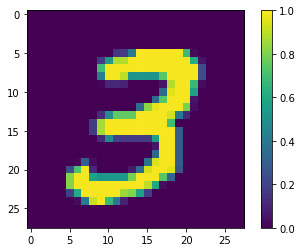

In [7]:
plt.imshow(x_train[0, :, :, 0])
plt.colorbar()

In [8]:
x_train_small = tf.image.resize(x_train, (4,4)).numpy()
x_test_small = tf.image.resize(x_test, (4,4)).numpy()

True


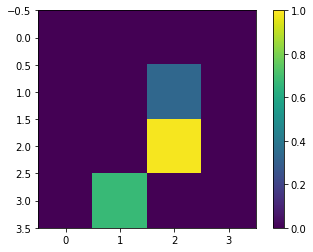

In [9]:
print(y_train[0])

plt.imshow(x_train_small[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()

In [10]:
THRESHOLD = 0.5

x_train_bin = np.array(x_train_small > THRESHOLD, dtype=np.float32)
x_test_bin = np.array(x_test_small > THRESHOLD, dtype=np.float32)

In [11]:
def margolus(circ, t, c0, c1):
        circ.ry(np.pi/4,t)
        circ.cx(c0, t)
        circ.ry(np.pi/4,t)
        circ.cx(c1, t)
        circ.ry(-np.pi/4,t)
        circ.cx(c0, t)
        circ.ry(-np.pi/4,t)

def rccx(circ, t, c0, c1):
        circ.h(t)
        circ.t(t)
        circ.cx(c0, t)
        circ.tdg(t)
        circ.cx(c1, t)
        circ.t(t)
        circ.cx(c0, t)
        circ.tdg(t)
        circ.h(t)

def rcccx(circ, t, c0, c1, c2):
        circ.h(t)
        circ.t(t)
        circ.cx(c0, t)
        circ.tdg(t)
        circ.h(t)
        circ.cx(c1, t)
        circ.t(t)
        circ.cx(c2, t)
        circ.tdg(t)
        circ.cx(c1, t)
        circ.t(t)
        circ.cx(c2, t)
        circ.tdg(t)
        circ.h(t)
        circ.t(t)
        circ.cx(c0, t)
        circ.tdg(t)
        circ.h(t)


def ccry(circ, angle, t, c0, c1):
        circ.cu3(angle/2, 0, 0, c1, t)
        circ.cx(c1, c0)
        circ.cu3(-angle/2, 0, 0, c0, t)
        circ.cx(c1, c0)
        circ.cu3(angle/2, 0, 0, c0, t)

def mary(circ, angle, t, c0, c1):
        circ.ry(angle/4,t)
        circ.cx(c0, t)
        circ.ry(-angle/4,t)
        circ.cx(c1, t)
        circ.ry(angle/4,t)
        circ.cx(c0, t)
        circ.ry(-angle/4,t)
        circ.cx(c1, t)

def cccry(circ, angle, t, a, c0, c1, c2):
        margolus(circ, a, c1, c2)
        mary(circ, angle, t, a, c0)
        margolus(circ, a, c1, c2)

def mary_4(circ, angle, t, c0, c1, c2):
        circ.h(t)
        circ.t(t)
        circ.cx(c0,t)
        circ.tdg(t)
        circ.h(t)
        circ.cx(c1,t)
        circ.rz(angle/4,t)
        circ.cx(c2,t)
        circ.rz(-angle/4,t)
        circ.cx(c1,t)
        circ.rz(angle/4,t)
        circ.cx(c2,t)
        circ.rz(-angle/4,t)
        circ.h(t)
        circ.t(t)
        circ.cx(c0,t)
        circ.tdg(t)
        circ.h(t)

def mary_8(circ, angle, t, c0, c1, c2, c3, c4, c5, c6):
        circ.h(t)
        circ.t(t)
        rccx(circ, t, c0, c1)
        circ.tdg(t)
        circ.h(t)
        rccx(circ, t, c2, c3)
        circ.rz(angle/4,t)
        rcccx(circ, t, c4, c5, c6)
        circ.rz(-angle/4,t)
        rccx(circ, t, c2, c3)
        circ.rz(angle/4,t)
        rcccx(circ, t, c4, c5, c6)
        circ.rz(-angle/4,t)
        circ.h(t)
        circ.t(t)
        rccx(circ, t, c0, c1)
        circ.tdg(t)
        circ.h(t)

def c10ry(circ, angle, bin, target, anc, controls):

        clist = []

        for i in bin:
                clist.append(int(i))

        for i in range(len(clist)):
                if clist[i] == 0:
                        circ.x(controls[-i-1])

        margolus(circ, anc, controls[0], controls[1])
        circ.x(controls[0])
        circ.x(controls[1])
        margolus(circ, controls[1], controls[2], controls[3])
        circ.x(controls[2])
        circ.x(controls[3])
        margolus(circ, controls[3], controls[4], controls[5])
        circ.x(controls[4])
        circ.x(controls[5])
        
        margolus(circ, controls[5], controls[8], controls[9])
        margolus(circ, controls[4], controls[6], controls[7])
        margolus(circ, controls[2], controls[4], controls[5])
        margolus(circ, controls[0], controls[2], controls[3])

        mary_4(circ, angle, target, anc, controls[0], controls[1])

        margolus(circ, controls[0], controls[2], controls[3])
        margolus(circ, controls[2], controls[4], controls[5])
        margolus(circ, controls[4], controls[6], controls[7])
        margolus(circ, controls[5], controls[8], controls[9])
        
        circ.x(controls[5])
        circ.x(controls[4])
        margolus(circ, controls[3], controls[4], controls[5])
        circ.x(controls[3])
        circ.x(controls[2])
        margolus(circ, controls[1], controls[2], controls[3])
        circ.x(controls[1])
        circ.x(controls[0])
        margolus(circ, anc, controls[0], controls[1])

        for i in range(len(clist)):
                if clist[i] == 0:
                        circ.x(controls[-i-1])

def c10mary(circ, angle, bin, target, anc, controls):
        clist = []

        for i in bin:
                clist.append(int(i))

        for i in range(len(clist)):
                if clist[i] == 0:
                        circ.x(controls[-i-1])

        rccx(circ, anc, controls[4], controls[5])
        circ.x(controls[4])
        circ.x(controls[5])
        rccx(circ, controls[4], controls[6], controls[7])
        rccx(circ, controls[5], controls[8], controls[9])


        mary_8(circ, angle, target, anc, controls[0], controls[1], controls[2], controls[3], controls[4], controls[5])

        rccx(circ, controls[5], controls[8], controls[9])
        rccx(circ, controls[4], controls[6], controls[7])
        circ.x(controls[5])
        circ.x(controls[4])
        rccx(circ, anc, controls[4], controls[5])

        for i in range(len(clist)):
                if clist[i] == 0:
                        circ.x(controls[-i-1])

In [12]:
def convert_to_circuit(image):
    """Encode truncated classical image into quantum datapoint."""
    values = np.ndarray.flatten(image)
    qubits = cirq.GridQubit.rect(4, 4)
    circuit = cirq.Circuit()
    for i, value in enumerate(values):
        if value:

            circuit.append(cirq.H(qubits[i]))

            for i in range(len(image)):
                    if image.all() != 0:
                            c10mary(qc, 2 * image[i], format(i, '010b'), 0, 1, [i for i in range(2,12)])
    return circuit


x_train_circ = [convert_to_circuit(x) for x in x_train_bin]
x_test_circ = [convert_to_circuit(x) for x in x_test_bin]

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


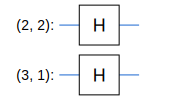

In [14]:
SVGCircuit(x_train_circ[0])

In [15]:
bin_img = x_train_bin[0,:,:,0]
indices = np.array(np.where(bin_img)).T
indices

array([[2, 2],
       [3, 1]])

In [16]:
x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

In [17]:
class CircuitLayerBuilder():
    def __init__(self, data_qubits, readout):
        self.data_qubits = data_qubits
        self.readout = readout
    
    def add_layer(self, circuit, gate, prefix):
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i))
            circuit.append(gate(qubit, self.readout)**symbol)

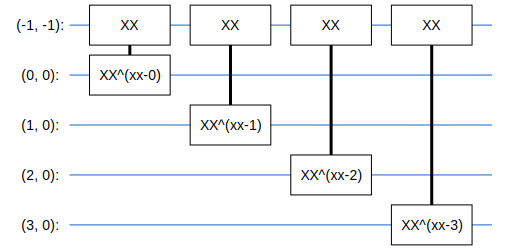

In [18]:
demo_builder = CircuitLayerBuilder(data_qubits = cirq.GridQubit.rect(4,1),
                                   readout=cirq.GridQubit(-1,-1))

circuit = cirq.Circuit()
demo_builder.add_layer(circuit, gate = cirq.XX, prefix='xx')
SVGCircuit(circuit)

In [19]:
def create_quantum_model():
    """Create a QNN model circuit and readout operation to go along with it."""
    data_qubits = cirq.GridQubit.rect(4, 4)  # a 4x4 grid.
    readout = cirq.GridQubit(-1, -1)         # a single qubit at [-1,-1]
    circuit = cirq.Circuit()
    
    # Prepare the readout qubit.
    circuit.append(cirq.X(readout))
    circuit.append(cirq.H(readout))
    
    builder = CircuitLayerBuilder(
        data_qubits = data_qubits,
        readout=readout)

    # Then add layers (experiment by adding more).
    builder.add_layer(circuit, cirq.XX, "xx1")
    builder.add_layer(circuit, cirq.ZZ, "zz1")

    # Finally, prepare the readout qubit.
    circuit.append(cirq.H(readout))

    return circuit, cirq.Z(readout)

In [20]:
model_circuit, model_readout = create_quantum_model()


In [21]:
# Build the Keras model.
model = tf.keras.Sequential([
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    # The PQC layer returns the expected value of the readout gate, range [-1,1].
    tfq.layers.PQC(model_circuit, model_readout),
])

In [22]:
y_train_hinge = 2.0*y_train-1.0
y_test_hinge = 2.0*y_test-1.0

In [23]:
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

In [24]:
model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])

In [25]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc (PQC)                    (None, 1)                 32        
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________
None


In [26]:
EPOCHS = 3
BATCH_SIZE = 128

NUM_EXAMPLES = len(x_train_tfcirc)

In [27]:
x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

In [28]:
import time
start_time = time.time()

In [29]:
qnn_history = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=128,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge))

qnn_results = model.evaluate(x_test_tfcirc, y_test)

Epoch 1/3
95/95 [==============================] - 648s 7s/step - loss: 0.9893 - hinge_accuracy: 0.7900 - val_loss: 0.9414 - val_hinge_accuracy: 0.7959
Epoch 2/3
95/95 [==============================] - 649s 7s/step - loss: 0.8050 - hinge_accuracy: 0.8006 - val_loss: 0.6949 - val_hinge_accuracy: 0.8013
Epoch 3/3
62/62 [==============================] - 16s 254ms/step - loss: 0.6285 - hinge_accuracy: 0.9138


In [30]:
print("--- %s saniye ---" % (time.time() - start_time))

--- 1979.675419807434 saniye ---


In [31]:
qnn_accuracy = qnn_results[1]
qnn_accuracy

0.9138104915618896

In [42]:
model.predict_classes(x_train_tfcirc[6:7])

array([[1]], dtype=int32)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


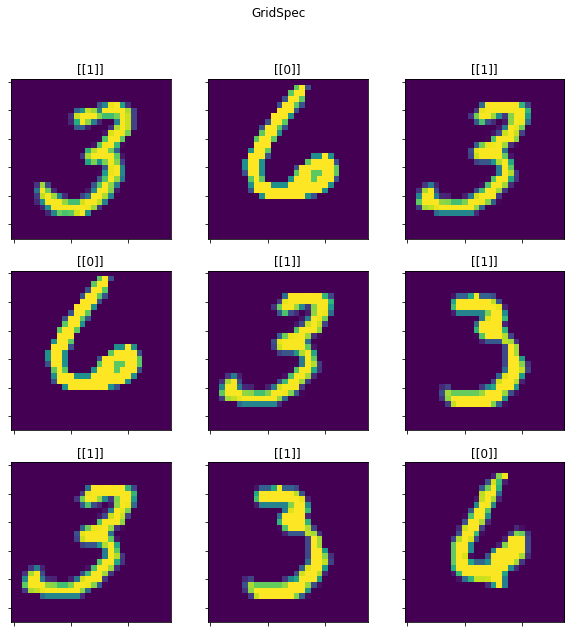

In [54]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec

def format_axes(fig):
    for i, ax in enumerate(fig.axes):
        ax.tick_params(labelbottom=False, labelleft=False)

fig = plt.figure(figsize=(10, 10))

gs = GridSpec(3, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
# identical to ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=3))

for i in range(3):
  for j in range(3):
    ax = fig.add_subplot(gs[i, j])
    ax.title.set_text(str(model.predict_classes(x_train_tfcirc[(i+j+65):(i+j+66)])))
    ax.imshow(x_train[i+j+65, :, :, 0])

fig.suptitle("GridSpec")
format_axes(fig)

plt.show()